## Feature Engineering and CV based Winners' Solutions

Try to use MAP@7 as `feval` for xgboost, failed because no way to tell xgboost how to group results by users. **Can only do this after train is finished.**

New in this notebook:
- A hacky implementation of MAP@7 evaluation. 
- This method is suitable when training on one month and validate on another month, since ncodpers is the key in ground truth dictionaries.
- This method **only works if the MAP functions and training codes are in the same notebook**.
- The MAP values shown during training is averaged by the number of customers with new products, so very different from LB. But it gives a sense of if the algorithm is good or not.
- **`exp(0.6/n-0.6)` is the best weights**

To-do: 
- mean encoding of products grouped by combinations of: canal_entrada, segmento, cod_prov
- Time since change and lags for a few non-product features: 
    - segmento
    - ind_actividad_cliente
    - cod_prov
    - canal_entrada
    - indrel_1mes
    - tiprel_1mes


Features:
- before eda_4_29
    - average of products for each (customer, product) pair
    - exponent weighted average of products each (customer, product) pair
    - time since presence of products, distance to the first 1
    - time to the last positive flank (01)
    - time to the last negative flank (10)
    - time to the last 1, to the nearest product purchase
    - time to the first 1, to the first product purchase
    - Trained@2015-06-28, validated@2015-12-28, mlogloss=1.28481
    - Private score: 0.0302054, public score: 0.0298683
- before eda_4_25
    - customer info in the second month
    - products in the first month
    - combination of first and second month `ind_actividad_cliente`
    - combination of first and second month `tiprel_1mes`
    - combination of first month product by using binary number (`target_combine`)
    - encoding `target_combine` with 
        - mean number of new products
        - mean number of customers with new products
        - mean number of customers with each new products
    - Count patterns in the last `max_lag` months
    - Number of month to the last time the customer purchase each product
        - CV@2015-12-28: mlogloss=1.29349
        - Private score: 0.0302475, public score: 0.0299266
- eda_4_25
    - Use all available history data
        - E.g., for 2016-05-28 train data, use all previous months, for 2015-02-28, use 1 lag month. 
        - Need to create test set that use the same amount of previous months for each training data set. 
        - This is from [the second winner's solution](https://www.kaggle.com/c/santander-product-recommendation/discussion/26824), his bold part in paragraph 4.
    - Combine models trained on 2016-05-28 and 2015-06-28:
        - Private score: 0.0304583, public score: 0.0300839
        - This is to catch both seasonality and trend, presented in 2015-06-28 and 2016-05-28, respectively. 
        - This idea is mentioned by many winners, like [11-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823) and [14-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26808)

- eda_4_27
    - put 2015-06-28 and 2016-05-28 in the same data set, with the same lag=5
        - Private score:0.0303096, public score: 0.0299867
        - Different as [11-th winner's discussion](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823)
            > We tested this by adding 50% of May-16 data to our June model and sure enough, we went from 0.0301 to 0.0303. Then, we built separate models for Jun and May, but the ensemble didn’t work. We weren’t surprised because June data is better for seasonal products, and May data is better for trend products. And vice-versa, June data is bad for trend products and May data is bad for seasonal products. So, they sort of cancelled each other out.

        - But my score is always worse than theirs, maybe this is the reason why we have different observations

# Compare two weights

In [1]:
from santander_helper import *

In [2]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0,
         'booster': 'gbtree', 
         'rate_drop': 0.1, 
         'skip_drop': 0.5,
         'normalize_type': 'tree', 
         'sample_type': 'uniform'}
num_rounds = 150
month_train = '2015-06-28'
month_val = '2016-05-28'
weights = [0]

history, model_dict = cv_month(param, num_rounds, month_train, month_val, n_repeat=10, random_seed=240,
                    lag_train=5, lag_val=5, weight_set=weights, verbose_eval=True)

Start weight index 0
##################################################
Train with weight 0, repetition 0 of 10
[0]	train-mlogloss:2.60425	val-mlogloss:2.62383	train-MAP@7:0.965764	val-MAP@7:0.966186
[1]	train-mlogloss:2.37049	val-mlogloss:2.40824	train-MAP@7:0.968731	val-MAP@7:0.969017
[2]	train-mlogloss:2.19028	val-mlogloss:2.23464	train-MAP@7:0.96984	val-MAP@7:0.969573
[3]	train-mlogloss:2.04255	val-mlogloss:2.09247	train-MAP@7:0.970237	val-MAP@7:0.968859
[4]	train-mlogloss:1.91691	val-mlogloss:1.97318	train-MAP@7:0.970679	val-MAP@7:0.969217
[5]	train-mlogloss:1.80801	val-mlogloss:1.87292	train-MAP@7:0.971197	val-MAP@7:0.969538
[6]	train-mlogloss:1.71225	val-mlogloss:1.78091	train-MAP@7:0.971523	val-MAP@7:0.969978
[7]	train-mlogloss:1.6262	val-mlogloss:1.69603	train-MAP@7:0.971877	val-MAP@7:0.969981
[8]	train-mlogloss:1.54872	val-mlogloss:1.62029	train-MAP@7:0.972144	val-MAP@7:0.970012
[9]	train-mlogloss:1.47858	val-mlogloss:1.55229	train-MAP@7:0.972239	val-MAP@7:0.969995
[10]	train

[90]	train-mlogloss:0.358063	val-mlogloss:0.431205	train-MAP@7:0.983485	val-MAP@7:0.96977
[91]	train-mlogloss:0.356429	val-mlogloss:0.429454	train-MAP@7:0.983595	val-MAP@7:0.969837
[92]	train-mlogloss:0.354852	val-mlogloss:0.427888	train-MAP@7:0.98365	val-MAP@7:0.969834
[93]	train-mlogloss:0.353279	val-mlogloss:0.426341	train-MAP@7:0.983747	val-MAP@7:0.969995
[94]	train-mlogloss:0.351702	val-mlogloss:0.424974	train-MAP@7:0.983896	val-MAP@7:0.969937
[95]	train-mlogloss:0.350185	val-mlogloss:0.423346	train-MAP@7:0.984125	val-MAP@7:0.969942
[96]	train-mlogloss:0.34876	val-mlogloss:0.422222	train-MAP@7:0.984184	val-MAP@7:0.969988
[97]	train-mlogloss:0.347357	val-mlogloss:0.420852	train-MAP@7:0.984288	val-MAP@7:0.969946
[98]	train-mlogloss:0.345955	val-mlogloss:0.419678	train-MAP@7:0.984303	val-MAP@7:0.969953
[99]	train-mlogloss:0.344614	val-mlogloss:0.41834	train-MAP@7:0.98442	val-MAP@7:0.969906
[100]	train-mlogloss:0.343398	val-mlogloss:0.41721	train-MAP@7:0.984532	val-MAP@7:0.969948
[101

[29]	train-mlogloss:0.757054	val-mlogloss:0.852327	train-MAP@7:0.976155	val-MAP@7:0.969203
[30]	train-mlogloss:0.738439	val-mlogloss:0.834085	train-MAP@7:0.976338	val-MAP@7:0.969059
[31]	train-mlogloss:0.720824	val-mlogloss:0.815531	train-MAP@7:0.976313	val-MAP@7:0.96906
[32]	train-mlogloss:0.703904	val-mlogloss:0.798634	train-MAP@7:0.97659	val-MAP@7:0.969085
[33]	train-mlogloss:0.687878	val-mlogloss:0.782192	train-MAP@7:0.976665	val-MAP@7:0.969081
[34]	train-mlogloss:0.672851	val-mlogloss:0.766634	train-MAP@7:0.976917	val-MAP@7:0.969053
[35]	train-mlogloss:0.658236	val-mlogloss:0.751471	train-MAP@7:0.977096	val-MAP@7:0.969112
[36]	train-mlogloss:0.644339	val-mlogloss:0.737386	train-MAP@7:0.977175	val-MAP@7:0.969082
[37]	train-mlogloss:0.631097	val-mlogloss:0.723748	train-MAP@7:0.977364	val-MAP@7:0.969166
[38]	train-mlogloss:0.618432	val-mlogloss:0.70983	train-MAP@7:0.9775	val-MAP@7:0.969258
[39]	train-mlogloss:0.606317	val-mlogloss:0.69712	train-MAP@7:0.977652	val-MAP@7:0.969253
[40]	

[120]	train-mlogloss:0.322984	val-mlogloss:0.404103	train-MAP@7:0.986344	val-MAP@7:0.969534
[121]	train-mlogloss:0.322083	val-mlogloss:0.403481	train-MAP@7:0.986431	val-MAP@7:0.969506
[122]	train-mlogloss:0.321333	val-mlogloss:0.40297	train-MAP@7:0.986458	val-MAP@7:0.969581
[123]	train-mlogloss:0.320573	val-mlogloss:0.402451	train-MAP@7:0.986491	val-MAP@7:0.969513
[124]	train-mlogloss:0.319779	val-mlogloss:0.401858	train-MAP@7:0.986639	val-MAP@7:0.969494
[125]	train-mlogloss:0.319055	val-mlogloss:0.401243	train-MAP@7:0.986662	val-MAP@7:0.969577
[126]	train-mlogloss:0.318289	val-mlogloss:0.400706	train-MAP@7:0.986736	val-MAP@7:0.969556
[127]	train-mlogloss:0.317598	val-mlogloss:0.400203	train-MAP@7:0.986841	val-MAP@7:0.969509
[128]	train-mlogloss:0.316827	val-mlogloss:0.399684	train-MAP@7:0.986845	val-MAP@7:0.969555
[129]	train-mlogloss:0.31617	val-mlogloss:0.399088	train-MAP@7:0.986977	val-MAP@7:0.969607
[130]	train-mlogloss:0.315457	val-mlogloss:0.398614	train-MAP@7:0.987067	val-MAP@7

[60]	train-mlogloss:0.444972	val-mlogloss:0.524661	train-MAP@7:0.980503	val-MAP@7:0.969259
[61]	train-mlogloss:0.44023	val-mlogloss:0.519445	train-MAP@7:0.980649	val-MAP@7:0.96918
[62]	train-mlogloss:0.43574	val-mlogloss:0.514472	train-MAP@7:0.980656	val-MAP@7:0.96922
[63]	train-mlogloss:0.431322	val-mlogloss:0.509512	train-MAP@7:0.980815	val-MAP@7:0.969353
[64]	train-mlogloss:0.427099	val-mlogloss:0.504898	train-MAP@7:0.980975	val-MAP@7:0.969313
[65]	train-mlogloss:0.423053	val-mlogloss:0.500888	train-MAP@7:0.98105	val-MAP@7:0.969306
[66]	train-mlogloss:0.419156	val-mlogloss:0.496975	train-MAP@7:0.981154	val-MAP@7:0.969287
[67]	train-mlogloss:0.415364	val-mlogloss:0.49303	train-MAP@7:0.981323	val-MAP@7:0.969294
[68]	train-mlogloss:0.411745	val-mlogloss:0.489641	train-MAP@7:0.981411	val-MAP@7:0.969217
[69]	train-mlogloss:0.408221	val-mlogloss:0.485829	train-MAP@7:0.981522	val-MAP@7:0.969188
[70]	train-mlogloss:0.404842	val-mlogloss:0.482116	train-MAP@7:0.981597	val-MAP@7:0.969239
[71]	

Validate logloss = 0.39179, MAP@7 = 0.96920, time = 13.62 min
--------------------------------------------------

Train with weight 0, repetition 3 of 10
[0]	train-mlogloss:2.60285	val-mlogloss:2.61934	train-MAP@7:0.965838	val-MAP@7:0.967782
[1]	train-mlogloss:2.37096	val-mlogloss:2.41051	train-MAP@7:0.967939	val-MAP@7:0.965887
[2]	train-mlogloss:2.19096	val-mlogloss:2.23916	train-MAP@7:0.969164	val-MAP@7:0.966339
[3]	train-mlogloss:2.04343	val-mlogloss:2.10062	train-MAP@7:0.969702	val-MAP@7:0.965512
[4]	train-mlogloss:1.91795	val-mlogloss:1.97834	train-MAP@7:0.970263	val-MAP@7:0.966256
[5]	train-mlogloss:1.80906	val-mlogloss:1.87286	train-MAP@7:0.97066	val-MAP@7:0.966578
[6]	train-mlogloss:1.7129	val-mlogloss:1.7786	train-MAP@7:0.97098	val-MAP@7:0.967532
[7]	train-mlogloss:1.62719	val-mlogloss:1.69597	train-MAP@7:0.971272	val-MAP@7:0.96769
[8]	train-mlogloss:1.55067	val-mlogloss:1.61988	train-MAP@7:0.97147	val-MAP@7:0.968152
[9]	train-mlogloss:1.48042	val-mlogloss:1.55477	train-MAP@7:

[90]	train-mlogloss:0.358007	val-mlogloss:0.432596	train-MAP@7:0.983477	val-MAP@7:0.969713
[91]	train-mlogloss:0.356287	val-mlogloss:0.430791	train-MAP@7:0.983651	val-MAP@7:0.969673
[92]	train-mlogloss:0.354697	val-mlogloss:0.429178	train-MAP@7:0.983795	val-MAP@7:0.969726
[93]	train-mlogloss:0.353144	val-mlogloss:0.427734	train-MAP@7:0.983874	val-MAP@7:0.969695
[94]	train-mlogloss:0.351644	val-mlogloss:0.426111	train-MAP@7:0.983963	val-MAP@7:0.96969
[95]	train-mlogloss:0.350136	val-mlogloss:0.424546	train-MAP@7:0.984084	val-MAP@7:0.96973
[96]	train-mlogloss:0.348688	val-mlogloss:0.423369	train-MAP@7:0.984156	val-MAP@7:0.96975
[97]	train-mlogloss:0.347313	val-mlogloss:0.422098	train-MAP@7:0.984242	val-MAP@7:0.969734
[98]	train-mlogloss:0.346008	val-mlogloss:0.420776	train-MAP@7:0.984255	val-MAP@7:0.969717
[99]	train-mlogloss:0.34468	val-mlogloss:0.419459	train-MAP@7:0.984432	val-MAP@7:0.969774
[100]	train-mlogloss:0.3434	val-mlogloss:0.418351	train-MAP@7:0.984486	val-MAP@7:0.969684
[101

[29]	train-mlogloss:0.757526	val-mlogloss:0.844392	train-MAP@7:0.975747	val-MAP@7:0.969085
[30]	train-mlogloss:0.738844	val-mlogloss:0.826518	train-MAP@7:0.97599	val-MAP@7:0.969071
[31]	train-mlogloss:0.721138	val-mlogloss:0.808537	train-MAP@7:0.976158	val-MAP@7:0.969082
[32]	train-mlogloss:0.704415	val-mlogloss:0.791213	train-MAP@7:0.976415	val-MAP@7:0.96899
[33]	train-mlogloss:0.688338	val-mlogloss:0.774806	train-MAP@7:0.976477	val-MAP@7:0.968901
[34]	train-mlogloss:0.673021	val-mlogloss:0.759188	train-MAP@7:0.976607	val-MAP@7:0.968958
[35]	train-mlogloss:0.658487	val-mlogloss:0.744803	train-MAP@7:0.976802	val-MAP@7:0.968902
[36]	train-mlogloss:0.644561	val-mlogloss:0.731197	train-MAP@7:0.976937	val-MAP@7:0.969008
[37]	train-mlogloss:0.631306	val-mlogloss:0.717927	train-MAP@7:0.977135	val-MAP@7:0.969063
[38]	train-mlogloss:0.618613	val-mlogloss:0.705976	train-MAP@7:0.977338	val-MAP@7:0.968821
[39]	train-mlogloss:0.606583	val-mlogloss:0.693612	train-MAP@7:0.977425	val-MAP@7:0.968762
[

[120]	train-mlogloss:0.322758	val-mlogloss:0.404522	train-MAP@7:0.986345	val-MAP@7:0.968975
[121]	train-mlogloss:0.321952	val-mlogloss:0.403945	train-MAP@7:0.986451	val-MAP@7:0.969002
[122]	train-mlogloss:0.321274	val-mlogloss:0.403266	train-MAP@7:0.98658	val-MAP@7:0.969004
[123]	train-mlogloss:0.320499	val-mlogloss:0.402725	train-MAP@7:0.986531	val-MAP@7:0.968979
[124]	train-mlogloss:0.319795	val-mlogloss:0.40218	train-MAP@7:0.986652	val-MAP@7:0.968923
[125]	train-mlogloss:0.319111	val-mlogloss:0.4016	train-MAP@7:0.986715	val-MAP@7:0.96897
[126]	train-mlogloss:0.318394	val-mlogloss:0.401075	train-MAP@7:0.986847	val-MAP@7:0.968912
[127]	train-mlogloss:0.317736	val-mlogloss:0.400621	train-MAP@7:0.986902	val-MAP@7:0.968792
[128]	train-mlogloss:0.317048	val-mlogloss:0.400062	train-MAP@7:0.986965	val-MAP@7:0.968829
[129]	train-mlogloss:0.316395	val-mlogloss:0.39969	train-MAP@7:0.987099	val-MAP@7:0.968842
[130]	train-mlogloss:0.315749	val-mlogloss:0.399151	train-MAP@7:0.987153	val-MAP@7:0.9

[60]	train-mlogloss:0.445104	val-mlogloss:0.525227	train-MAP@7:0.980419	val-MAP@7:0.969221
[61]	train-mlogloss:0.440372	val-mlogloss:0.520047	train-MAP@7:0.980528	val-MAP@7:0.969077
[62]	train-mlogloss:0.435916	val-mlogloss:0.515281	train-MAP@7:0.980615	val-MAP@7:0.969138
[63]	train-mlogloss:0.431534	val-mlogloss:0.510726	train-MAP@7:0.98075	val-MAP@7:0.969168
[64]	train-mlogloss:0.427393	val-mlogloss:0.506207	train-MAP@7:0.98087	val-MAP@7:0.969134
[65]	train-mlogloss:0.423382	val-mlogloss:0.502019	train-MAP@7:0.981004	val-MAP@7:0.969119
[66]	train-mlogloss:0.419472	val-mlogloss:0.497594	train-MAP@7:0.981068	val-MAP@7:0.969183
[67]	train-mlogloss:0.41572	val-mlogloss:0.493589	train-MAP@7:0.981237	val-MAP@7:0.969181
[68]	train-mlogloss:0.412163	val-mlogloss:0.489679	train-MAP@7:0.981284	val-MAP@7:0.969136
[69]	train-mlogloss:0.408665	val-mlogloss:0.485744	train-MAP@7:0.981329	val-MAP@7:0.969142
[70]	train-mlogloss:0.405308	val-mlogloss:0.482262	train-MAP@7:0.981569	val-MAP@7:0.969112
[7

Validate logloss = 0.39305, MAP@7 = 0.96954, time = 13.61 min
--------------------------------------------------

Train with weight 0, repetition 6 of 10
[0]	train-mlogloss:2.60267	val-mlogloss:2.62786	train-MAP@7:0.966193	val-MAP@7:0.96666
[1]	train-mlogloss:2.37074	val-mlogloss:2.40911	train-MAP@7:0.968148	val-MAP@7:0.966502
[2]	train-mlogloss:2.19091	val-mlogloss:2.24212	train-MAP@7:0.969535	val-MAP@7:0.967212
[3]	train-mlogloss:2.04302	val-mlogloss:2.10062	train-MAP@7:0.969977	val-MAP@7:0.967697
[4]	train-mlogloss:1.91771	val-mlogloss:1.98011	train-MAP@7:0.97085	val-MAP@7:0.967511
[5]	train-mlogloss:1.8088	val-mlogloss:1.88602	train-MAP@7:0.971232	val-MAP@7:0.968146
[6]	train-mlogloss:1.71274	val-mlogloss:1.79274	train-MAP@7:0.971549	val-MAP@7:0.968233
[7]	train-mlogloss:1.62681	val-mlogloss:1.70827	train-MAP@7:0.971764	val-MAP@7:0.968736
[8]	train-mlogloss:1.54932	val-mlogloss:1.6319	train-MAP@7:0.972413	val-MAP@7:0.969109
[9]	train-mlogloss:1.47919	val-mlogloss:1.56364	train-MAP@

[90]	train-mlogloss:0.357866	val-mlogloss:0.433948	train-MAP@7:0.983498	val-MAP@7:0.969496
[91]	train-mlogloss:0.356153	val-mlogloss:0.432341	train-MAP@7:0.983651	val-MAP@7:0.969515
[92]	train-mlogloss:0.354554	val-mlogloss:0.430682	train-MAP@7:0.983789	val-MAP@7:0.969586
[93]	train-mlogloss:0.353024	val-mlogloss:0.4289	train-MAP@7:0.983845	val-MAP@7:0.969559
[94]	train-mlogloss:0.351488	val-mlogloss:0.42748	train-MAP@7:0.983925	val-MAP@7:0.969509
[95]	train-mlogloss:0.350054	val-mlogloss:0.426166	train-MAP@7:0.984026	val-MAP@7:0.969528
[96]	train-mlogloss:0.34864	val-mlogloss:0.424708	train-MAP@7:0.984097	val-MAP@7:0.969585
[97]	train-mlogloss:0.347244	val-mlogloss:0.423292	train-MAP@7:0.984311	val-MAP@7:0.969526
[98]	train-mlogloss:0.345912	val-mlogloss:0.42216	train-MAP@7:0.984371	val-MAP@7:0.969486
[99]	train-mlogloss:0.344597	val-mlogloss:0.420894	train-MAP@7:0.984496	val-MAP@7:0.969555
[100]	train-mlogloss:0.34329	val-mlogloss:0.419885	train-MAP@7:0.984598	val-MAP@7:0.969577
[101

[29]	train-mlogloss:0.757297	val-mlogloss:0.848757	train-MAP@7:0.975995	val-MAP@7:0.969345
[30]	train-mlogloss:0.738683	val-mlogloss:0.830298	train-MAP@7:0.976252	val-MAP@7:0.969479
[31]	train-mlogloss:0.721084	val-mlogloss:0.811843	train-MAP@7:0.976255	val-MAP@7:0.969379
[32]	train-mlogloss:0.704209	val-mlogloss:0.794296	train-MAP@7:0.97642	val-MAP@7:0.969406
[33]	train-mlogloss:0.688273	val-mlogloss:0.777234	train-MAP@7:0.976483	val-MAP@7:0.969435
[34]	train-mlogloss:0.673027	val-mlogloss:0.761794	train-MAP@7:0.976639	val-MAP@7:0.969496
[35]	train-mlogloss:0.658447	val-mlogloss:0.747394	train-MAP@7:0.976808	val-MAP@7:0.969438
[36]	train-mlogloss:0.644548	val-mlogloss:0.733983	train-MAP@7:0.976965	val-MAP@7:0.96946
[37]	train-mlogloss:0.631417	val-mlogloss:0.719955	train-MAP@7:0.977295	val-MAP@7:0.969451
[38]	train-mlogloss:0.618742	val-mlogloss:0.706668	train-MAP@7:0.977531	val-MAP@7:0.9694
[39]	train-mlogloss:0.606672	val-mlogloss:0.694088	train-MAP@7:0.977665	val-MAP@7:0.96932
[40]

[120]	train-mlogloss:0.323231	val-mlogloss:0.40381	train-MAP@7:0.98621	val-MAP@7:0.969419
[121]	train-mlogloss:0.322397	val-mlogloss:0.40318	train-MAP@7:0.986371	val-MAP@7:0.969418
[122]	train-mlogloss:0.321632	val-mlogloss:0.402742	train-MAP@7:0.986367	val-MAP@7:0.969436
[123]	train-mlogloss:0.320882	val-mlogloss:0.402202	train-MAP@7:0.986476	val-MAP@7:0.969415
[124]	train-mlogloss:0.320119	val-mlogloss:0.401726	train-MAP@7:0.986523	val-MAP@7:0.969531
[125]	train-mlogloss:0.319413	val-mlogloss:0.401248	train-MAP@7:0.986601	val-MAP@7:0.969415
[126]	train-mlogloss:0.318676	val-mlogloss:0.400632	train-MAP@7:0.986693	val-MAP@7:0.969402
[127]	train-mlogloss:0.317967	val-mlogloss:0.400182	train-MAP@7:0.986802	val-MAP@7:0.969401
[128]	train-mlogloss:0.317274	val-mlogloss:0.399894	train-MAP@7:0.986831	val-MAP@7:0.96938
[129]	train-mlogloss:0.316582	val-mlogloss:0.399469	train-MAP@7:0.986878	val-MAP@7:0.969345
[130]	train-mlogloss:0.315945	val-mlogloss:0.399113	train-MAP@7:0.986904	val-MAP@7:0

[59]	train-mlogloss:0.449777	val-mlogloss:0.529786	train-MAP@7:0.980149	val-MAP@7:0.96952
[60]	train-mlogloss:0.44488	val-mlogloss:0.524782	train-MAP@7:0.980145	val-MAP@7:0.969551
[61]	train-mlogloss:0.440192	val-mlogloss:0.519698	train-MAP@7:0.980341	val-MAP@7:0.969401
[62]	train-mlogloss:0.435666	val-mlogloss:0.514535	train-MAP@7:0.980432	val-MAP@7:0.969576
[63]	train-mlogloss:0.431292	val-mlogloss:0.509993	train-MAP@7:0.980552	val-MAP@7:0.969553
[64]	train-mlogloss:0.427049	val-mlogloss:0.50553	train-MAP@7:0.980717	val-MAP@7:0.9695
[65]	train-mlogloss:0.423003	val-mlogloss:0.501623	train-MAP@7:0.980792	val-MAP@7:0.969457
[66]	train-mlogloss:0.419088	val-mlogloss:0.497648	train-MAP@7:0.980965	val-MAP@7:0.969525
[67]	train-mlogloss:0.415312	val-mlogloss:0.493581	train-MAP@7:0.981086	val-MAP@7:0.969449
[68]	train-mlogloss:0.411633	val-mlogloss:0.489954	train-MAP@7:0.981206	val-MAP@7:0.96936
[69]	train-mlogloss:0.408135	val-mlogloss:0.486663	train-MAP@7:0.981384	val-MAP@7:0.969488
[70]	

Validate logloss = 0.39057, MAP@7 = 0.96953, time = 13.63 min
--------------------------------------------------

Train with weight 0, repetition 9 of 10
[0]	train-mlogloss:2.60299	val-mlogloss:2.63462	train-MAP@7:0.966174	val-MAP@7:0.961578
[1]	train-mlogloss:2.37199	val-mlogloss:2.41841	train-MAP@7:0.968929	val-MAP@7:0.966529
[2]	train-mlogloss:2.19168	val-mlogloss:2.24656	train-MAP@7:0.96951	val-MAP@7:0.96737
[3]	train-mlogloss:2.04419	val-mlogloss:2.10251	train-MAP@7:0.969741	val-MAP@7:0.96806
[4]	train-mlogloss:1.91859	val-mlogloss:1.98256	train-MAP@7:0.970139	val-MAP@7:0.967947
[5]	train-mlogloss:1.80953	val-mlogloss:1.87869	train-MAP@7:0.970662	val-MAP@7:0.968308
[6]	train-mlogloss:1.71316	val-mlogloss:1.78764	train-MAP@7:0.971068	val-MAP@7:0.968707
[7]	train-mlogloss:1.62713	val-mlogloss:1.70527	train-MAP@7:0.971462	val-MAP@7:0.968899
[8]	train-mlogloss:1.54979	val-mlogloss:1.62971	train-MAP@7:0.971907	val-MAP@7:0.968882
[9]	train-mlogloss:1.47935	val-mlogloss:1.56211	train-MAP

[90]	train-mlogloss:0.357852	val-mlogloss:0.433301	train-MAP@7:0.983597	val-MAP@7:0.969738
[91]	train-mlogloss:0.356164	val-mlogloss:0.43155	train-MAP@7:0.983728	val-MAP@7:0.969789
[92]	train-mlogloss:0.354593	val-mlogloss:0.429995	train-MAP@7:0.983796	val-MAP@7:0.969683
[93]	train-mlogloss:0.353062	val-mlogloss:0.428295	train-MAP@7:0.983918	val-MAP@7:0.969635
[94]	train-mlogloss:0.351474	val-mlogloss:0.426875	train-MAP@7:0.984011	val-MAP@7:0.969698
[95]	train-mlogloss:0.350063	val-mlogloss:0.42545	train-MAP@7:0.984046	val-MAP@7:0.969717
[96]	train-mlogloss:0.348622	val-mlogloss:0.424053	train-MAP@7:0.984149	val-MAP@7:0.969665
[97]	train-mlogloss:0.347265	val-mlogloss:0.422783	train-MAP@7:0.984248	val-MAP@7:0.969694
[98]	train-mlogloss:0.345939	val-mlogloss:0.421558	train-MAP@7:0.984281	val-MAP@7:0.969611
[99]	train-mlogloss:0.344666	val-mlogloss:0.420333	train-MAP@7:0.984395	val-MAP@7:0.969648
[100]	train-mlogloss:0.343445	val-mlogloss:0.419092	train-MAP@7:0.984486	val-MAP@7:0.969617


In [3]:
#history_prev = pd.read_csv('weight_cv_2_history.csv', header=[0, 1, 2, 3], index_col=0)
#history_prev.columns.set_levels(history_prev.columns.levels[0].astype(int), level=0, inplace=True) # convert string to int
#history_prev.columns.set_levels(history_prev.columns.levels[1].astype(int), level=1, inplace=True) # convert string to int
val = {}

# load previous result w=exp(1/n-1)
#val[1, 'mean'] = history_prev.xs(axis=1, level=[0, 2, 3], key=(9, 'val', 'MAP@7')).apply('mean', axis=1)
#val[1, 'std'] = history_prev.xs(axis=1, level=[0, 2, 3], key=(9, 'val', 'MAP@7')).apply('std', axis=1)

# process current results
for idx, metric in itertools.product(weights, ['mean', 'std']):
    val[(idx, metric)] = history.xs(axis=1, level=[0, 2, 3], key=(idx, 'val', 'MAP@7')).apply(metric, axis=1)

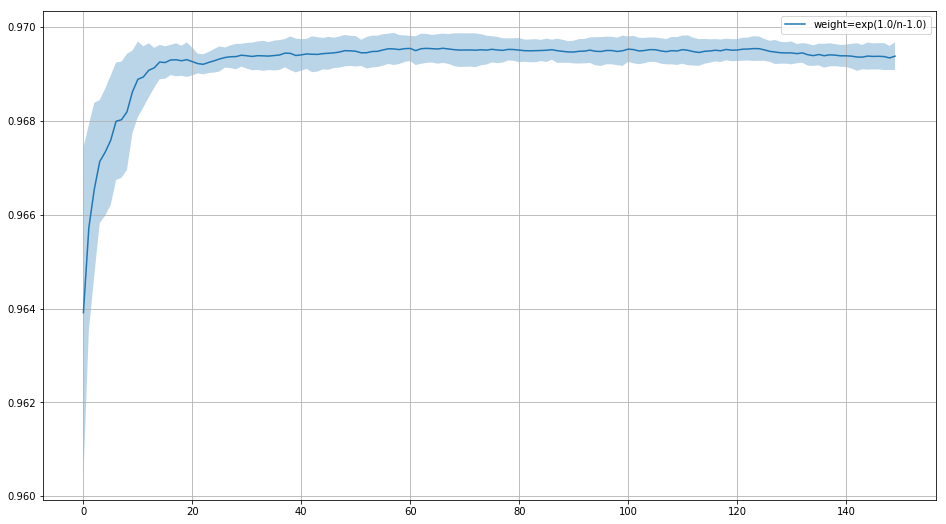

In [4]:
plt.figure(figsize=(16, 9))

#plt.plot(val[1, 'mean'], label='weight=exp(1/n-1)')
#plt.fill_between(history_prev.index, val[1, 'mean']-val[1, 'std'], val[1, 'mean']+val[1, 'std'], alpha=0.3)

nd = {0: 1.0}
for idx in weights:
    plt.plot(val[idx, 'mean'], label='weight=exp({}/n-{})'.format(nd[idx], nd[idx]))
    plt.fill_between(history.index, val[idx, 'mean']-val[idx, 'std'], val[idx, 'mean']+val[idx, 'std'], alpha=0.3)

plt.grid()
#plt.xlim(60, 120)
#plt.ylim(0.854, 0.86)
plt.legend()

In [5]:
history.to_csv('weight_cv_5_history.csv')

In [6]:
save_pickle('weight_cv_5_models.pickle', model_dict)

## Feature importance

In [9]:
fi = {}
for n in range(7):
    fi[n] = model_dict[0][n].get_score(importance_type='gain')
fi = pd.DataFrame(fi)
fi['mean'] = fi.iloc[:, :7].mean(axis=1)
fi['std'] = fi.iloc[:, :7].std(axis=1)
#fi.drop(list(range(7)), axis=1, inplace=True)

In [10]:
fi.sort_values('mean', ascending=False, inplace=True)

In [11]:
fi.shape

(462, 9)

(462, -0.5)

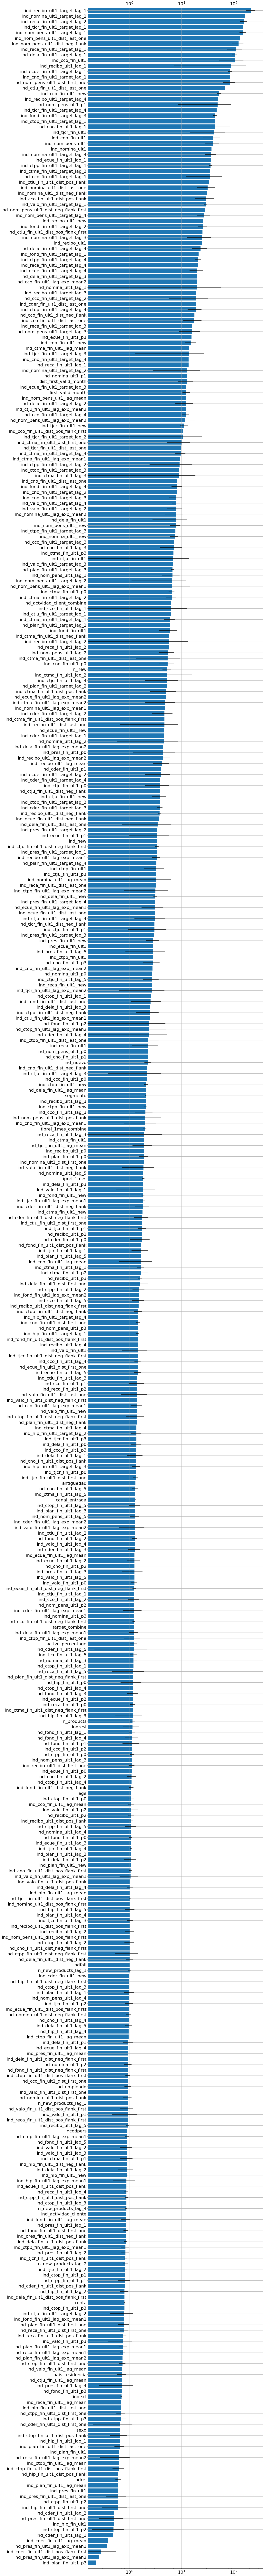

In [12]:
plt.rcParams.update({'figure.figsize': '16, 240'})
plt.rcParams.update({'font.size': '22'})
fig, ax = plt.subplots()
ax.barh(fi.index, fi['mean'].values, log=True, xerr=fi['std'].values)
ax.grid()
ax.tick_params(labelbottom=True,labeltop=True)
ax.set_ylim(fi.shape[0], -0.5)

In [13]:
sum(fi['mean']<2)/len(fi)

0.5670995670995671

In [15]:
fi.to_hdf('feature_importance_eda_4_29.hdf', 'feature_importance')

C:\Users\lyaa\AppData\Local\Continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
C:\Users\lyaa\AppData\Local\Continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


In [14]:
x_train

NameError: name 'x_train' is not defined